In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
__file__ = './'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

# os.path.dirname(__file__)获取当前文件的绝对路径
# os.path.join(xx,'..')在后面追加..，相当于进入上一级目录
# os.path.abspath(xx)获取绝对路径
# sys.path.append()将其加入系统路径当中

import MSA
import LINK

In [3]:
# read data
my_link = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='link_info')
my_link['I'] = 0
my_node = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='node_info')
my_link['name'] = my_link['from'].astype('str') +'-'+ my_link['to'].astype('str')
my_demand = pd.read_excel(r'D:\004_PhD_Dissertation\Paper_Code\Part3\input_network\small_net.xlsx', sheet_name='demand_info')
print(my_demand)

# set parameter
origin_zone = ['r1']
destination_zone = ['s1']
theta_1 = 1 # path 
theta_2 = 0.5 # mode
# miu_in = 25
# miu_out = 30
lamda_0_hailing = 2 #2 RMB/minute
lamda_0_PR = 20 # RMB
lamda_0_transit = 5
N_hailing = 500
lamda_0_auto = LINK.compute_lamda_0_auto(fuel_consumption=8.5)

df = []
VOT_lst = np.arange(0, 101, 5)
for VOT in VOT_lst:
    miu_in = VOT
    miu_out = 1.2 * miu_in
    result = MSA.assignment(my_link= my_link, my_node= my_node, my_demand= my_demand,
                        origin_zone= origin_zone, destination_zone= destination_zone,
                        miu_in= miu_in, miu_out= miu_out,
                        lamda_0_auto= lamda_0_auto,
                        lamda_0_hailing= lamda_0_hailing,
                        lamda_0_transit= lamda_0_transit,
                        lamda_0_PR= lamda_0_PR,
                        theta_1= theta_1, theta_2= theta_2,
                        N_hailing= N_hailing, A=2, maximum_iter=300)
    df.append(result)

# system cost
total_cost = []
for item in df:
    flow_set = item[2].tail(item[6])
    cost = sum(abs(flow_set['path_cost']) * flow_set['path_flow'])
    total_cost.append(cost)

# OD cost
def od_cost(path, od):
    cost = sum(abs(path[path['OD_pair'] == od]['path_cost']) * path[path['OD_pair'] == od]['path_flow'])
    return cost

od_1_cost = []
od_2_cost = []
od_3_cost = []
od_4_cost = []
for i in range(len(df)):
    flow_set = df[i][2].tail(df[i][6])
    od_1_cost.append(od_cost(flow_set, 'r1-s1'))
    od_2_cost.append(od_cost(flow_set, 'r1-s2'))
    od_3_cost.append(od_cost(flow_set, 'r2-s1'))
    od_4_cost.append(od_cost(flow_set, 'r2-s2'))

# mode share
PR_logit = [df[i][4].tail(df[i][7]).iloc[0]['mode_logit'] for i in range(len(df))]
RT_logit = [df[i][4].tail(df[i][7]).iloc[1]['mode_logit'] for i in range(len(df))]
auto_logit = [df[i][4].tail(df[i][7]).iloc[2]['mode_logit'] for i in range(len(df))]
bus_logit = [df[i][4].tail(df[i][7]).iloc[3]['mode_logit'] for i in range(len(df))]

# path_flow
path_1_flow = [df[i][2].tail(df[i][6]).iloc[0]['path_flow'] for i in range(len(df))]
path_2_flow = [df[i][2].tail(df[i][6]).iloc[1]['path_flow'] for i in range(len(df))]
path_3_flow = [df[i][2].tail(df[i][6]).iloc[2]['path_flow'] for i in range(len(df))]
path_4_flow = [df[i][2].tail(df[i][6]).iloc[3]['path_flow'] for i in range(len(df))]

# path_duration
path_1_duration = [df[i][2].tail(df[i][6]).iloc[0]['path_duration'] for i in range(len(df))]
path_2_duration = [df[i][2].tail(df[i][6]).iloc[1]['path_duration'] for i in range(len(df))]
path_3_duration = [df[i][2].tail(df[i][6]).iloc[2]['path_duration'] for i in range(len(df))]
path_4_duration = [df[i][2].tail(df[i][6]).iloc[3]['path_duration'] for i in range(len(df))]

# path_cost
path_1_cost = [abs(df[i][2].tail(df[i][6]).iloc[0]['path_cost']) for i in range(len(df))]
path_2_cost = [abs(df[i][2].tail(df[i][6]).iloc[1]['path_cost']) for i in range(len(df))]
path_3_cost = [abs(df[i][2].tail(df[i][6]).iloc[2]['path_cost']) for i in range(len(df))]
path_4_cost = [abs(df[i][2].tail(df[i][6]).iloc[3]['path_cost']) for i in range(len(df))]

# ride-hailing vehicle number
n_idle = [df[i][5].tail(1).iloc[0]['n_idle'] for i in range(len(df))]
waiting_hailing = [df[i][5].tail(1).iloc[0]['wait_time'] for i in range(len(df))]

# convert to dataframe
dfx = pd.DataFrame({
        'VOT': VOT_lst,
        'n_idle': n_idle,
        'waiting time': waiting_hailing,
        'total_cost': total_cost,
        'auto_logit': auto_logit,
        'bus_logit': bus_logit,
        'PR_logit': PR_logit,
        'RT_logit': RT_logit,
        'path_1_flow': path_1_flow,
        'path_2_flow': path_2_flow,
        'path_3_flow': path_3_flow,
        'path_4_flow': path_4_flow,
        'path_1_cost': path_1_cost,
        'path_2_cost': path_2_cost,
        'path_3_cost': path_3_cost,
        'path_4_cost': path_4_cost,
        'path_1_duration': path_1_duration,
        'path_2_duration': path_2_duration,
        'path_3_duration': path_3_duration,
        'path_4_duration': path_4_duration,})

  OD_pair  demand
0   r1-s1    1000
0.6517
['path-1', 'path-2', 'path-3', 'path-4']
['auto', 'P&R', 'transit', 'R&T']
Iteration = 1, gap = 1.3403711843802788,
the number of idle_hailing:500.0
Iteration = 2, gap = 18.07613129720505,
the number of idle_hailing:402.3984824222219
Iteration = 3, gap = 8.215347277017646,
the number of idle_hailing:399.63024474344564
Iteration = 4, gap = 5.244744810480197,
the number of idle_hailing:399.3737490256702
Iteration = 5, gap = 3.82569095331722,
the number of idle_hailing:399.26891004560656
Iteration = 6, gap = 2.9987364254067304,
the number of idle_hailing:399.20514552260715
Iteration = 7, gap = 2.4590784197840487,
the number of idle_hailing:399.1622610014764
Iteration = 8, gap = 2.080029085238265,
the number of idle_hailing:399.13167017969283
Iteration = 9, gap = 1.7996454208499648,
the number of idle_hailing:399.1088929915394
Iteration = 10, gap = 1.5841135626774965,
the number of idle_hailing:399.0913652058821
Iteration = 11, gap = 1.41343575294

In [4]:
dfx

,VOT,n_idle,waiting time,total_cost,auto_logit,bus_logit,PR_logit,RT_logit,path_1_flow,path_2_flow,path_3_flow,path_4_flow,path_1_cost,path_2_cost,path_3_cost,path_4_cost,path_1_duration,path_2_duration,path_3_duration,path_4_duration
0,0,398.981620,5.721226,48084.539213,0.233924,0.273368,0.237193,0.255515,233.959751,237.217322,273.309037,255.513890,84.685243,75.719890,5.000000,35.000000,31.936208,124.911482,147.420492,122.212199
1,5,399.334713,5.718817,58749.422964,0.237329,0.270631,0.237385,0.254655,237.342302,237.389828,270.621205,254.646665,88.562581,88.399522,17.833183,46.804427,32.380805,124.547643,146.712486,121.566499
2,10,399.660477,5.716597,69275.220842,0.240428,0.268099,0.237618,0.253855,240.441836,237.622036,268.089768,253.846360,92.459668,100.995232,30.558989,58.510996,32.806118,124.231158,146.068221,120.979801
3,15,399.963886,5.714531,79671.743646,0.243239,0.265765,0.237887,0.253109,243.254062,237.890057,265.755063,253.100818,96.356794,113.508914,43.193399,70.134327,33.207014,123.958015,145.487884,120.451546
4,20,400.245393,5.712617,89954.000317,0.245779,0.263620,0.238184,0.252417,245.793518,238.186900,263.610631,252.408951,100.244408,125.948623,55.750963,81.687736,33.582341,123.723787,144.967176,119.977828
5,25,400.506302,5.710845,100136.113857,0.248064,0.261656,0.238504,0.251775,248.078729,238.506705,261.646972,251.767594,104.115538,138.322399,68.244558,93.183009,33.931909,123.524058,144.501226,119.554195
6,30,400.747249,5.709209,110230.207862,0.250111,0.259865,0.238841,0.251183,250.125431,238.843391,259.855973,251.175206,107.962872,150.636755,80.685820,104.630799,34.255441,123.354987,144.085926,119.176899
7,35,400.969082,5.707705,120247.295273,0.251935,0.258237,0.239190,0.250637,251.950156,239.191597,258.228523,250.629724,111.780517,162.897720,93.085024,116.040516,34.553127,123.212985,143.717183,118.842201
8,40,401.172645,5.706325,130197.231542,0.253554,0.256764,0.239545,0.250137,253.569127,239.546523,256.755251,250.129099,115.563573,175.110698,105.451224,127.420453,34.825438,123.094795,143.391121,118.546557
9,45,401.358775,5.705065,140088.840363,0.254983,0.255435,0.239903,0.249679,254.998122,239.903957,255.426636,249.671285,119.308106,187.280555,117.792346,138.777868,35.073083,122.997478,143.104081,118.286620


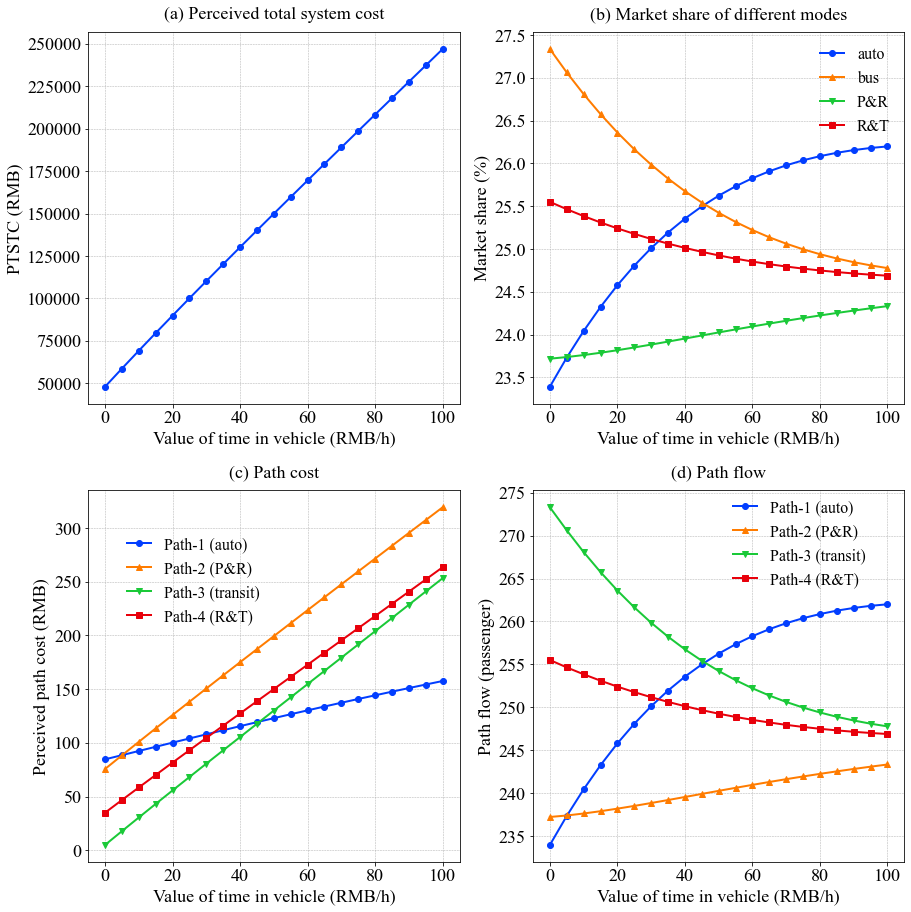

In [5]:
import seaborn as sns
sns.set_palette("bright", 10)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 18

fig = plt.figure(figsize=(13,13))
markers = ['o','^','v','s','h','D','p','<','>']

ax = plt.subplot(2,2,1)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['VOT'], dfx['total_cost'], '-', lw=2, marker='o')
ax.set_xlabel('Value of time in vehicle (RMB/h)')
ax.set_ylabel('PTSTC (RMB)')
ax.set_title('(a) Perceived total system cost', fontsize=18, loc='center', y=1.02)

ax = plt.subplot(2,2,2)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['VOT'], dfx['auto_logit']*100, '-', lw=2, marker=markers[0], label='auto')
ax.plot(dfx['VOT'], dfx['bus_logit']*100, '-', lw=2, marker=markers[1], label='bus')
ax.plot(dfx['VOT'], dfx['PR_logit']*100, '-', lw=2, marker=markers[2], label='P&R')
ax.plot(dfx['VOT'], dfx['RT_logit']*100, '-', lw=2, marker=markers[3], label='R&T')
ax.set_xlabel('Value of time in vehicle (RMB/h)')
ax.set_ylabel('Market share (%)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5) #, bbox_to_anchor=(0.7,0.7)
ax.set_title('(b) Market share of different modes', fontsize=18, loc='center', y=1.02,)

ax = plt.subplot(2,2,3)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['VOT'], dfx['path_1_cost'], '-', lw=2, marker='o',label='Path-1 (auto)')
ax.plot(dfx['VOT'], dfx['path_2_cost'], '-', lw=2, marker='^',label='Path-2 (P&R)')
ax.plot(dfx['VOT'], dfx['path_3_cost'], '-', lw=2, marker='v',label='Path-3 (transit)')
ax.plot(dfx['VOT'], dfx['path_4_cost'], '-', lw=2, marker='s',label='Path-4 (R&T)')
ax.set_xlabel('Value of time in vehicle (RMB/h)')
ax.set_ylabel('Perceived path cost (RMB)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5,bbox_to_anchor = (0.5,0.6)) #,bbox_to_anchor = (0.6,0.4)
ax.set_title('(c) Path cost', fontsize=18, loc='center', y=1.02)

ax = plt.subplot(2,2,4)
ax.grid(ls = '--', lw = 0.5, zorder = 0)
ax.plot(dfx['VOT'], dfx['path_1_flow'], '-', lw=2, marker='o',label='Path-1 (auto)')
ax.plot(dfx['VOT'], dfx['path_2_flow'], '-', lw=2, marker='^',label='Path-2 (P&R)')
ax.plot(dfx['VOT'], dfx['path_3_flow'], '-', lw=2, marker='v',label='Path-3 (transit)')
ax.plot(dfx['VOT'], dfx['path_4_flow'], '-', lw=2, marker='s',label='Path-4 (R&T)')
ax.set_xlabel('Value of time in vehicle (RMB/h)')
ax.set_ylabel('Path flow (passenger)')
ax.legend(loc='best', fontsize=16, frameon=False, handlelength=1.5, bbox_to_anchor = (0.5,0.7),)  
ax.set_title('(d) Path flow', fontsize=18, loc='center', y=1.02)

plt.tight_layout()
plt.show()